In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn.metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
data = pd.read_csv('data.csv')

In [2]:
#Remove "[", ")", ">", and "<"
data['age']=data['age'].str.replace('[','')
data['age']=data['age'].str.replace(')','')
data['weight']=data['weight'].str.replace('[','')
data['weight']=data['weight'].str.replace(')','')
data['max_glu_serum']=data['max_glu_serum'].str.replace('>','greater_than_')
data['A1Cresult']=data['A1Cresult'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('<','smaller_than_')

In [3]:
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,0-10,?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,10-20,?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,greater_than_30
2,64410,86047875,AfricanAmerican,Female,20-30,?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,30-40,?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,40-50,?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,50-60,?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,greater_than_30
6,55842,84259809,Caucasian,Male,60-70,?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,70-80,?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,greater_than_30
8,12522,48330783,Caucasian,Female,80-90,?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,90-100,?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
#Change categorical variables to one-hot vectors
df_2 = pd.get_dummies(data, columns=['race', 'gender','age','admission_type_id','discharge_disposition_id','admission_source_id','payer_code','medical_specialty','diag_1','diag_2','diag_3','max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','change','diabetesMed','readmitted'], drop_first=True)
#Create new variable 'readmitted_yes' for binary classification
df_2['readmitted_yes']=df_2['readmitted_greater_than_30']+df_2['readmitted_smaller_than_30']

In [8]:
df_2.head()

,encounter_id,patient_nbr,weight,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes,readmitted_greater_than_30,readmitted_smaller_than_30,readmitted_yes
0,2278392,8222157,?,1,41,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,149190,55629189,?,3,59,0,18,0,0,0,...,0,0,0,0,0,0,1,1,0,1
2,64410,86047875,?,2,11,5,13,2,0,1,...,0,0,0,0,0,1,1,0,0,0
3,500364,82442376,?,2,44,1,16,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,16680,42519267,?,1,51,0,8,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [19]:
#Construct predicted variable 'readmitted_yes' and predictors
Y=df_2['readmitted_yes']
X=df_2.drop('readmitted_yes',axis=1)
X=X.drop('readmitted_greater_than_30',axis=1)
X=X.drop('readmitted_smaller_than_30',axis=1)
X=X.drop('weight',axis=1)
X=X.drop('encounter_id',axis=1)
X=X.drop('patient_nbr',axis=1)

In [20]:
#Train test split
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [21]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [23]:
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions accuracy
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 64.07%


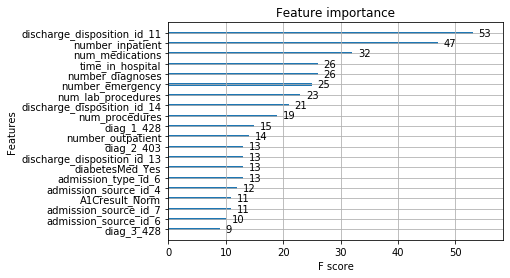

In [25]:
#importance plot
xgb.plot_importance(model, max_num_features=20)

In [11]:
data.groupby("readmitted")["readmitted"].describe().reset_index()

,readmitted,count,unique,top,freq
0,<30,11357,1,<30,11357
1,>30,35545,1,>30,35545
2,NO,54864,1,NO,54864


In [14]:
data.groupby("race")["race"].describe().reset_index()

,race,count,unique,top,freq
0,?,2273,1,?,2273
1,AfricanAmerican,19210,1,AfricanAmerican,19210
2,Asian,641,1,Asian,641
3,Caucasian,76099,1,Caucasian,76099
4,Hispanic,2037,1,Hispanic,2037
5,Other,1506,1,Other,1506


In [15]:
data.groupby("gender")["gender"].describe().reset_index()

,gender,count,unique,top,freq
0,Female,54708,1,Female,54708
1,Male,47055,1,Male,47055
2,Unknown/Invalid,3,1,Unknown/Invalid,3


In [16]:
data.groupby("age")["age"].describe().reset_index()

,age,count,unique,top,freq
0,[0-10),161,1,[0-10),161
1,[10-20),691,1,[10-20),691
2,[20-30),1657,1,[20-30),1657
3,[30-40),3775,1,[30-40),3775
4,[40-50),9685,1,[40-50),9685
5,[50-60),17256,1,[50-60),17256
6,[60-70),22483,1,[60-70),22483
7,[70-80),26068,1,[70-80),26068
8,[80-90),17197,1,[80-90),17197
9,[90-100),2793,1,[90-100),2793


In [18]:
data.groupby("weight")["weight"].describe().reset_index()#majority missing

,weight,count,unique,top,freq
0,>200,3,1,>200,3
1,?,98569,1,?,98569
2,[0-25),48,1,[0-25),48
3,[100-125),625,1,[100-125),625
4,[125-150),145,1,[125-150),145
5,[150-175),35,1,[150-175),35
6,[175-200),11,1,[175-200),11
7,[25-50),97,1,[25-50),97
8,[50-75),897,1,[50-75),897
9,[75-100),1336,1,[75-100),1336


In [ ]:
#tried multiclass xgboost
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4))

# You may need to use MultiLabelBinarizer to encode your variables from arrays [[x, y, z]] to a multilabel 
# format before training.
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)

clf.fit(X_train, y_train)